# Re-reduce STIS spectra

The STIS pipeline reduction does not automatically associate frames that were taken with integer pixel dithers along the slit. These can be used for CR rejection, but they need to be properly combined in a custom run of the pipeline. 

This link identifies the above as a reason you may want to recalibrate STIS data: <br>
https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-5-recalibration-of-stis-data <br>

It also describes the steps that are necessary in order to redo the CR rejection. I will need to register the relevant frames in a \_flt file, feed this to ocrrejct, and then propagate that through to the 1D extraction.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import pandas as pd
import matplotlib.patches as mpatch
import glob
from astropy.io import fits
import ftplib
import stistools
import os
import shutil

# for drizzlepac
from astroquery.mast import Observations
import os
import shutil
import stwcs
import subprocess 

# for basic2d
from stistools import basic2d
#from stsci.tools import teal
#teal.teal("basic2d")

# for tweakreg and astrodrizzle
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from IPython.display import Image

from pathlib import Path


%matplotlib inline

import sys
sys.path.insert(0,'C:\\Users\\serat\\Downloads\\AGN')
from convenience_functions import show_image
from astropy.nddata import CCDData, StdDevUncertainty


In [36]:
def retrieve_hst_data(stagedir,datadir):
#-------------------------------------------------------------
#+
# NAME:
#       RETRIEVE_HST_DATA
#
# PURPOSE:                                                 
#   Download data from the HST archive after they have been staged.
#
#   This is written following the example at:
#   https://archive.stsci.edu/ftp.html
#
# CALLING SEQUENCE:
#       retrieve_hst_data(stagedir)
#
# INPUTS:
#   stagedir - the remote directory emailed from the archive, will be something like
#              'anonymous/anonymous98473'
#   datadir  - the local directory to write data to
#
#
# NOTES:
#
#
# EXAMPLE:
# 
#
# MODIFICATION HISTORY:
#    JCR, 17 Oct 2022: VERSION 3.00
#       - Converted to Python 3
#    JCR, 26 July 2016; VERSION 2.00
#       -  Added flux uncertainty propagation.
#       -  Also fixed some bugs:
#       -  There was a bug where the first point was
#          always set to zero. 
#    JCR, 04 December 2015: VERSION 1.00
#       -  Started writing the first version of the code.
#
#-
#-------------------------------------------------------------    
    user     = 'anonymous'
    password = 'serat.mahmud.saad@vanderbilt.edu'
    
    ftps = ftplib.FTP_TLS('archive.stsci.edu')
    ftps.login(user=user, passwd=password)
    ftps.prot_p() # This is a really good idea :)
    ftps.cwd('stage')
    ftps.cwd(stagedir) # stagedir is something like 'anonymous/anonyumous12345'

    filenames = ftps.nlst()
    for filename in filenames:
        print("writing " + datadir+filename)
        with open(datadir+filename, 'wb') as fp: 
            ftps.retrbinary('RETR {}'.format(filename), fp.write)

## Download a clean copy of the STIS data

In [37]:
# this won't work on Colfax or Shasta without changes
# this assumes matching BBH directory structure
# will have been started from py/ so go up one
raw_dir     = 'C:/Users/serat/Downloads/AGN/data/raw/'
pipe_dir    = 'C:/Users/serat/Downloads/AGN/data/pipe/'
reduced_dir    = 'C:/Users/serat/Downloads/AGN/data/reduced/'

# make the directories if they doesn't exist
Path(reduced_dir).mkdir(exist_ok=True)

# go to your pipeline reduction directory
os.chdir(reduced_dir)
print("Current directory is: "+os.getcwd())


Current directory is: C:\Users\serat\Downloads\AGN\data\reduced


In [38]:
# set download defaults
download_raw   = True
download_calib = True

# note that this can take a long time
if download_raw:
    retrieve_hst_data('anonymous/anonymous16822',raw_dir)

writing C:/Users/serat/Downloads/AGN/data/raw/16j16005o_apd.fits
writing C:/Users/serat/Downloads/AGN/data/raw/16j16006o_sdc.fits
writing C:/Users/serat/Downloads/AGN/data/raw/16j1600co_wcp.fits
writing C:/Users/serat/Downloads/AGN/data/raw/16j1600do_ccd.fits
writing C:/Users/serat/Downloads/AGN/data/raw/3ah1528ao_tds.fits
writing C:/Users/serat/Downloads/AGN/data/raw/71d1605oo_drk.fits
writing C:/Users/serat/Downloads/AGN/data/raw/71d1605to_bia.fits
writing C:/Users/serat/Downloads/AGN/data/raw/71d16061o_bia.fits
writing C:/Users/serat/Downloads/AGN/data/raw/71d16063o_bia.fits
writing C:/Users/serat/Downloads/AGN/data/raw/71d16064o_drk.fits
writing C:/Users/serat/Downloads/AGN/data/raw/74e15479o_pht.fits
writing C:/Users/serat/Downloads/AGN/data/raw/77o18274o_imp.fits
writing C:/Users/serat/Downloads/AGN/data/raw/h1v11475o_bpx.fits
writing C:/Users/serat/Downloads/AGN/data/raw/h4s1351lo_pfl.fits
writing C:/Users/serat/Downloads/AGN/data/raw/h5s11397o_iac.fits
writing C:/Users/serat/Do

In [39]:
raw_dir = 'C:/Users/serat/Downloads/AGN/data/raw/'
reduced_dir = 'C:/Users/serat/Downloads/AGN/data/reduced/'

os.makedirs(reduced_dir, exist_ok=True)

os.chdir(raw_dir)

raw_files = np.sort(glob.glob('*_raw.fits'))

for file in raw_files:
    shutil.copy(file, reduced_dir)

epc_files = np.sort(glob.glob('*_epc.fits'))
wav_files = np.sort(glob.glob('*_wav.fits'))

for file in epc_files:
    shutil.copy(file, reduced_dir)

for file in wav_files:
    shutil.copy(file, reduced_dir)

os.chdir(reduced_dir)
print("Current Directory:", os.getcwd())

raw_files = np.sort(glob.glob('*_raw.fits'))
print(raw_files)

Current Directory: C:\Users\serat\Downloads\AGN\data\reduced
['of0a02010_raw.fits' 'of0a02020_raw.fits' 'of0a02030_raw.fits'
 'of0a02040_raw.fits' 'of0a02050_raw.fits' 'of0a02060_raw.fits'
 'of0a02070_raw.fits' 'of0a02080_raw.fits' 'of0a02090_raw.fits'
 'of0a020a0_raw.fits' 'of0a02acq_raw.fits']


### Verify reference files

There are two ways to do this:
1. Get the reference files from MAST. To do this, click the "Used Reference Files" box when you download the data package from MAST. I did this, so I got all of the reference files taken at the time of the data in my raw/ directory.

2. Alternatively, you can download references files independently to make sure you get the most up-to-date data. astroconda has a package that does the download for you, but you have to run it in a bash shell. Open a bash terminal and run the following script to do the download: /Users/runnojc1/Research/work/psu/ilarion1/runnoejc/Research/projects/smbbh/BBH/uvspec/stis_reduce/data/crds_cache/download_ref_files.sh

I did option 1 above, so just set the environment variable to my raw data directory (which has science and reference files all together).

You can also follow directions here for data downloads: <br>
https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/Initialization/Initialization.html

In [40]:
# set environment variables
# to point to wherever you put the ref files
#%env lref /Users/runnojc1/crds_cache/references/hst/stis/
#%env oref /Users/runnojc1/crds_cache/references/hst/stis/

%env lref C:/Users/serat/Downloads/AGN/data/raw/
%env oref C:/Users/serat/Downloads/AGN/data/raw/

env: lref=C:/Users/serat/Downloads/AGN/data/raw/
env: oref=C:/Users/serat/Downloads/AGN/data/raw/


In [41]:
# update the pmap file in the file headers
#%env CRDS_PATH /Users/runnojc1/crds_cache
#%env CRDS_SERVER_URL https://hst-crds.stsci.edu
#%env oref /Users/runnojc1/crds_cache/references/hst/oref/
#
#os.system('crds bestrefs --update-bestrefs --sync-references=1 --files *_raw.fits')
#os.system('crds bestrefs --update-bestrefs --sync-references=1 --files *_wav.fits')

# Reduce the data

This will follow my calstis_manual notebook with one exception. [Section 3.5.4](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-5-recalibration-of-stis-data#id-3.5RecalibrationofSTISData-3.5.23.5.2RerunningSubsetsoftheCalibrationPipeline) describes how to implement better CR rejection in the STIS pipeline. The relevant detail is that CR rejection uses a Poisson noise model, so to get this right you have to do the bias subtraction, then align images from multiple dithers, then do CR rejection, then continue with the rest of the pipeline steps starting with dark and flat corrections.

## Do the bias subtraction

First, initialize the DQ and ERR arrays and do the bias level and bias frame subtraction.

In [43]:
# do the bias correction
# loop over the raw files
# this will handle multiple CRSPLIT extensions per file
for raw_file in raw_files:
    print('Reducing '+raw_file+'.')
    # get the root filename
    file = raw_file.replace('_raw.fits','',1)

    # run the bias level and frame subtraction
    # when running manually, express the correction to perform in command line
    print('    Starting bias subtraction...')
    stistools.basic2d.basic2d(input=reduced_dir+raw_file,output=reduced_dir+file+'_blv_tmp.fits',
                              verbose=True,trailer=reduced_dir+file+'_trl.fits',
                              dqicorr='perform',
                              blevcorr='perform',
                              biascorr='perform',
                              darkcorr='omit',
                              flatcorr='omit',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit',
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=False)
    print('Done.')

    # make a flat without CR rejection
    print('Starting dark and flat corrections for non-CR frame...')
    stistools.basic2d.basic2d(input=reduced_dir+file+'_blv_tmp.fits',output=reduced_dir+file+'_flt.fits',
                              verbose=True,trailer=reduced_dir+file+'_trl.log',
                              dqicorr='omit',
                              blevcorr='omit',
                              biascorr='omit',
                              darkcorr='perform',
                              flatcorr='perform',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit', 
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=True)    
    print('Done.')

Reducing of0a02010_raw.fits.
    Starting bias subtraction...
Running basic2d on C:/Users/serat/Downloads/AGN/data/reduced/of0a02010_raw.fits
  ['cs1.e', '-v', 'C:/Users/serat/Downloads/AGN/data/reduced/of0a02010_raw.fits', 'C:/Users/serat/Downloads/AGN/data/reduced/of0a02010_blv_tmp.fits', '-dqi', '-blev', '-bias']


FileNotFoundError: [WinError 2] The system cannot find the file specified

## Align the images

Each target had 3 dither positions. We need to remove these shifts, verify that the optical path was stable, and make sure there was no target drift during the exposures. The steps for this are generally described in [Section 5.4.5](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-4-working-with-spectral-images), with some further references included below.

### Shift the dithered exposures

Follow [Section 5.4.5](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-4-working-with-spectral-images) to align the images. This step should be performed on the pipeline _flt files which have been bias, flat, and dark corrected. Then, shift all dithered frames using the POSTARG2 keyword, which recorded the dither along the slit. These will appear as _sfl files in the reduced directory. 

In [47]:
# grab the bias subtracted files
# use an image collection so it is easy to grab obj names
imgs = ImageFileCollection(reduced_dir, glob_include="*_flt.fits",\
                                   keywords=["TARGNAME","RA_TARG","DEC_TARG","POSTARG1","POSTARG2","asn_id","TEXPTIME","CRSPLIT","DETECTOR","OPT_ELEM",\
                                             "APERTURE","FILTER",'CENWAVE',"CCDGAIN"])

# get the target name
obj_name = np.unique(imgs.summary['TARGNAME'].data.data)[0]
# get a list of unique filters
filters = np.unique(imgs.summary['CENWAVE'].data.data)

# get a list of _flt files
in_files = imgs.files_filtered(include_path=False)

# display a summary
summary_table = imgs.summary
summary_table

TypeError: 'NoneType' object is not subscriptable

In [48]:
# actually, the POSTARG2 keyword in the headers stores the dither-along-slit step values
# the Python package sshift can correct this, it works on my bias corrected _flt files.

# loop over each object
for fltr in filters:
    # file management
    obj_files = imgs.files_filtered(TARGNAME=obj_name,CENWAVE=fltr)
    in_files  = [reduced_dir+obj_file for obj_file in obj_files]
    out_files = [reduced_dir+obj_file.replace('_flt.fits','_sfl_tmp.fits',1) for obj_file in obj_files]
    root_file = obj_files[0].replace('_flt.fits','',1)
                 
    # clean out existing _sfl file if it exists
    # sshift will crash otherwise
    for file in out_files:
        if os.path.exists(file): 
            os.system('rm '+file)
     
    # grab header keywords and apply the dither correction
    platescale = fits.getval(in_files[0],'PLATESC')
    postarg2 = fits.getval(in_files[0],'POSTARG2')
    stistools.sshift.sshift(in_files, 
                            output=out_files, 
                            shifts=None, 
                            platescale=platescale, 
                            tolerance=np.abs(postarg2)*1.15) # seems to work if tolerance is a little bigger than the dither
    
    # take a look
    # check that it worked
    # the first image should be unshifted, so the difference should be zero
    # subsequent frames should have mismatched hotspots from the first frame but the trace should disappear
    flt0 = CCDData.read(in_files[0],unit='adu')
    flt1 = CCDData.read(in_files[1],unit='adu')
    flt2 = CCDData.read(in_files[2],unit='adu')
    
    sfl0 = CCDData.read(in_files[0].replace('_flt.fits','_sfl_tmp.fits',1),unit='adu')
    sfl1 = CCDData.read(in_files[1].replace('_flt.fits','_sfl_tmp.fits',1),unit='adu')
    sfl2 = CCDData.read(in_files[2].replace('_flt.fits','_sfl_tmp.fits',1),unit='adu')
    
    fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 20))
    show_image(flt0.data-sfl0.data, cmap='gray', ax=ax1, fig=fig)
    ax1.set_title('Orig/Shift 1',size=30)
    show_image(flt0.data-sfl1.data, cmap='gray', ax=ax2, fig=fig)
    ax2.set_title('Orig/Shift 2',size=30)
    show_image(flt0.data-sfl2.data, cmap='gray', ax=ax3, fig=fig)
    ax3.set_title('Orig/Shift 3',size=30)  
    plt.tight_layout()
    plt.show() 

NameError: name 'filters' is not defined

## CR rejection and finish pipeline


In [49]:
in_files = np.sort(glob.glob('*_sfl_tmp.fits'))
in_files

array([], dtype=float64)

In [50]:
# do the bias correction
# loop over the raw files
# this will handle multiple CRSPLIT extensions per file
#for in_file in in_files:
for fltr in filters:
    print('Reducing CENWAVE='+str(fltr)+'.')
    # file management
    obj_files = imgs.files_filtered(TARGNAME=obj_name,CENWAVE=fltr)
    in_files = [reduced_dir+obj_file.replace('_flt.fits','_sfl_tmp.fits',1) for obj_file in obj_files]   
    in_str   = ','.join(map(str,in_files))
    
    # get the root filename
    file = obj_files[0].replace('_flt.fits','',1)        
    
    # now do the CR rejection
    print('    Starting CR rejection...')
    stistools.ocrreject.ocrreject(in_str,
                              reduced_dir+file+'_crj.fits',
                              verbose=True,
                              all=True,
                              trailer=reduced_dir+file+'_trl.log',
                              crsigmas='4',
                              crradius=1.5,
                              crthresh=0.8,
                              initgues='min')     
    print('Done.') 
    
    # run the bias level and frame subtraction
    print('Starting bias, dark, and flat corrections for '+file+'_wav.fits')
    stistools.basic2d.basic2d(input=reduced_dir+file+'_wav.fits',output=reduced_dir+file+'_fwv_tmp.fits',
                              verbose=True,trailer=reduced_dir+file+'_trl.log',
                              dqicorr='perform',
                              blevcorr='perform',
                              biascorr='perform',
                              darkcorr='perform',
                              flatcorr='perform',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit',
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=True)
    print('Done.')    
    
    # rectify the 2D spectral image
    print('Rectifying 2D spectral image...')
    stistools.x2d.x2d(input=reduced_dir+file+'_fwv_tmp.fits', output=reduced_dir+file+'_w2d_tmp.fits',
                      helcorr='omit', 
                      fluxcorr='omit',
                      statflag=False,
                      center=False,
                      blazeshift=None,
                      err_alg='wgt_var',
                      verbose=True,
                      trailer=reduced_dir+file+'_trl.log')  
    print('Done.')
    
    # now do the wavelength calibration for _crj
    print('Updating header keywords with wavecal info for '+file+'_crj.fits')
    stistools.wavecal.wavecal(reduced_dir+file+'_crj.fits',reduced_dir+file+'_w2d_tmp.fits', 
                              debugfile='', 
                              savetmp=False, 
                              option='linear', 
                              angle=None, 
                              verbose=True, 
                              timestamps=False, 
                              trailer=reduced_dir+file+'_trl.log', 
                              print_version=False, 
                              print_revision=False) 
    
    # now do the wavelength calibration for _flt
    print('Updating header keywords with wavecal info for '+file+'_flt.fits')
    stistools.wavecal.wavecal(reduced_dir+file+'_flt.fits',reduced_dir+file+'_w2d_tmp.fits', 
                              debugfile='', 
                              savetmp=False, 
                              option='linear', 
                              angle=None, 
                              verbose=True, 
                              timestamps=False, 
                              trailer=reduced_dir+file+'_trl.log', 
                              print_version=False, 
                              print_revision=False)   
    
    # rectify the 2D spectral image
    print('Rectifying 2D spectral image...')
    stistools.x2d.x2d(input=reduced_dir+file+'_crj.fits', output=reduced_dir+file+'_sx2.fits',
                      helcorr='perform', 
                      fluxcorr='perform',
                      statflag=False,
                      center=False,
                      blazeshift=None,
                      err_alg='wgt_var',
                      verbose=True,
                      trailer=reduced_dir+file+'_trl.log')  
    print('Done.')
    
    # extract the 1D spectrum
    print('Extracting the 1D spectrum...')
    stistools.x1d.x1d(reduced_dir+file+'_crj.fits', output=reduced_dir+file+'_sx1.fits', 
                      backcorr='perform', 
                      ctecorr='perform', 
                      dispcorr='perform', 
                      helcorr='perform', 
                      fluxcorr='perform', 
                      sporder=None, 
                      a2center=None, 
                      maxsrch=None, 
                      globalx=False, 
                      extrsize=None, 
                      bk1size=None, 
                      bk2size=None, 
                      bk1offst=None, 
                      bk2offst=None, 
                      bktilt=None, 
                      backord=None,bksmode='median',bksorder=3, 
                      blazeshift=None, 
                      algorithm='unweighted', 
                      xoffset=None, 
                      verbose=True,
                      timestamps=False, 
                      trailer=reduced_dir+file+'_trl.log')
    print('Done.')
     
    print('Cleaning up...')
    #os.system('rm *_tmp.fits')
    print('Done!')
  

NameError: name 'filters' is not defined

In [51]:
## START HERE NEXT TIME
# I'm combining 3 dither positions per instr setup and reducing those under the name of the first one
# I don't know if the approach to the wavelength extract (just grabbing the matching filename) is right
# The issue I'm having is that the STIS X1D is having a hard time getting a trace on the 040 image.
    # too short of an exposure?
    # wrong pointing?
    # didn't get the combination right up to this point?

files = glob.glob(reduced_dir+'*crj.fits')

for file in files:
    img = CCDData.read(file,unit='adu')
        
    fig,ax = plt.subplots(1, 1, figsize=(20, 20))
    show_image(img, cmap='gray', ax=ax, fig=fig)  
    plt.tight_layout()
    plt.show() 

ValueError: operands could not be broadcast together with shapes (0,) (2,) 

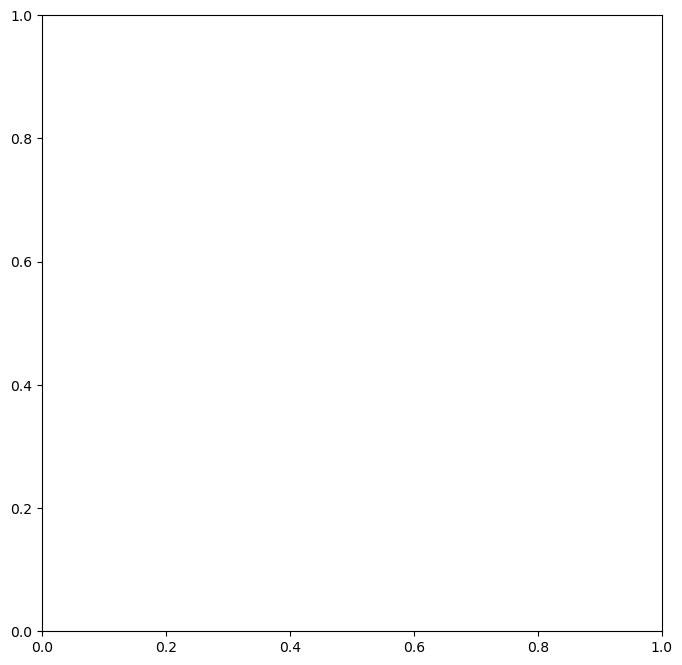

In [52]:
# check the CR rejection
crj_imgs = ImageFileCollection(reduced_dir, glob_include="*crj.fits",\
                                   keywords=["TARGNAME","RA_TARG","DEC_TARG","POSTARG1","POSTARG2","asn_id","TEXPTIME","CRSPLIT","DETECTOR","OPT_ELEM",\
                                             "APERTURE","FILTER","CCDGAIN"])

# get a list of _sfl files
crj_files = crj_imgs.files_filtered(include_path=False)

crjs    = [CCDData.read(file_name,unit='adu').data for file_name in crj_files]
crjs_ma = np.ma.masked_array(crjs,mask=np.full(np.shape(crjs), False, dtype=bool))
crj_mn  = np.ma.sum(crjs_ma,axis=0)
    
# visualize the CR rejection
fig,ax = plt.subplots(1, 1, figsize=(8,8))
show_image(crj_mn, cmap='gray', ax=ax, fig=fig)
ax.set_title('Summed CR')
plt.tight_layout()
plt.show() 

for frame in crjs:
    fig,ax = plt.subplots(1, 1, figsize=(8,8))
    show_image(frame.data/crj_mn.data, cmap='gray', ax=ax, fig=fig)
    ax.set_title('Indv. CR/Summed CR')
    plt.tight_layout()
    plt.show() 


In [53]:
# default
#crsigmas='4',
#crradius=1.5,
#initgues='min'

# not much better
#crsigmas='6,5,4',
#crradius=1.5,
#initgues='min'

# worse? vertical line at defective streak
#crsigmas='4',
#crradius=1.5,
#initgues='med'

# worse? vertical line at defective streak
#crsigmas='4',
#crradius=1,
#initgues='min'

## Compare to default

STIS keeps the 1D spectra in *_sx1.fits files. Compare the originally reduced pipeline files that I downloaded to the ones that I just created to see if I am reproducing the pipeline behavior well.

There seem to be some small differences in the noise spikes, but the reductions are both remarkable similar.

In [54]:
# my defaults are stored here
#orig_dir = '/Users/runnojc1/Dropbox/Research/BBH/uvspec/fits/'
#orig_dir = pipe_dir

# get filenames, which should be the same regardless of reduction
sx1_files = glob.glob(reduced_dir+'*sx1.fits')
sx1_files

[]

In [55]:
# loop over the files and plot both versions
for sx1_file in sx1_files:
    new_hdu = fits.open(sx1_file)
    new_dat = new_hdu[1].data
    wave_new = new_dat['wavelength'][0]
    flux_new = (1e17)*new_dat['flux'][0]
    err_new  = (1e17)*new_dat['error'][0]
    
    ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
    xtit = 'Observed Wavelength [\AA]'
    fig,ax1 = plt.subplots(1, 1, sharex=True,figsize=(16,8))
    ax1.plot(wave_new,flux_new,drawstyle='steps-mid',color='k')
    #ax1.set_ylim([0,1000])
    ax1.set_xlim([2800,5800])
    ax1.set_ylabel(ytit,size=22)
    plt.tight_layout()
    plt.show() 

        

### Verify image alignment
Section 5.4.4 [here](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-4-working-with-spectral-images) describes how to check for alignment in dithered spectral images. We need to verify that the images are well aligned (besides the dither that we removed with SSHIFT). This has two steps:

1. Check for stability in the optical path. These are done by checking the SHIFTA1 and SHIFTA2 keywords in the _flt or _sfl headers as described in Section 5.4.4 in the above link. These keywords have the following meaning: 

    SHIFTA1 - shift in pixels along the dispersion direction <br>
    SHIFTA2 - shift in pixels along the spatial direction

    Below, collect the SHIFTA1 and SHIFTA2 keywords in the _sfl files. Compare SHIFTA for both CR-SPLIT extensions and all three dither positions. These turn out to differ by ~0.02 pixels max, so the optical path is stable.
    
2. Check for target drift.

    First, [check if the target was observed in single guide star mode](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-2-evaluating-target-acquisitions-and-guiding#id-5.2EvaluatingTargetAcquisitionsandGuiding-5.2.6) (which is more prone to drift). This requires access to sections 6.3.1 and 6.3.2 in the Introduction to Data Handbook. The [current version of this handbook](https://hst-docs.stsci.edu/hstdhb/5-observation-logs/5-2-using-observation-logs) has only 5 chapters, so although the information is in there it is difficult to find. It helps to reference this [older version](https://www.stsci.edu/files/live/sites/www/files/home/hst/documentation/_documents/hstdh_intro.pdf).
    
    Generally, guiding will be done with FINE_LOCK using 1 or 2 guide stars. The keywords related to the dominant and roll guide stars (GSD and GSR) can be used to check if two guide stars were used. Also check the GUIDECMD adn GSFAIL keywords to see if the guiding failed. 
    
    In this case, all guiding was done with FINE_LOCK and 2 guide stars, so there should be no target drift. If there has been a guide failure, you'd need to calcuate target drift in the exposure.

In [56]:
# to verify that the images are now well aligned
# put them in an image collection
sfl_imgs = ImageFileCollection(reduced_dir, glob_include="*sfl_tmp.fits",\
                                   keywords=["TARGNAME","RA_TARG","DEC_TARG","POSTARG1","POSTARG2","asn_id","TEXPTIME","CRSPLIT","DETECTOR","OPT_ELEM",\
                                             "APERTURE","FILTER","CCDGAIN"])

# get a list of _sfl files
sfl_files = sfl_imgs.files_filtered(include_path=False)

# display a summary
sfl_summary_table = sfl_imgs.summary
sfl_summary_table

In [57]:
for obj in obj_names:
    # file management
    sfl_obj_files = sfl_imgs.files_filtered(TARGNAME=obj)   
    jif_obj_files = [raw_dir+sfl_file.replace('_sfl_tmp.fits','_jif.fits',1) for sfl_file in sfl_obj_files]
  

    # this will grab shifta1 from both CR-SPLIT extensions in list comprehension
    # then the sum(shifta1,[]) wrapper flattens it into a single list
    shifta1 = sum([[fits.getval(reduced_dir+sfl_file,'SHIFTA1',ext=1),fits.getval(reduced_dir+sfl_file,'SHIFTA1',ext=2)] for sfl_file in sfl_obj_files],[])
    shifta2 = sum([[fits.getval(reduced_dir+sfl_file,'SHIFTA2',ext=1),fits.getval(reduced_dir+sfl_file,'SHIFTA2',ext=2)] for sfl_file in sfl_obj_files],[])    
    print("Deviation for {0} in SHIFTA1,SHIFTA2: {1:.4f},{2:.4f}".format(obj,np.std(np.abs(shifta1)),np.std(np.abs(shifta2))))

    # get guide star keywords to check for target drift
    GSD_IDs = [fits.getval(jif_file,'GSD_ID',ext=0) for jif_file in jif_obj_files]
    GSR_IDs = [fits.getval(jif_file,'GSR_ID',ext=0) for jif_file in jif_obj_files]
    GCMDs   = [fits.getval(jif_file,'GUIDECMD',ext=0) for jif_file in jif_obj_files]
    
    # if all three dither positions aren't done with FINE_LOCK
    # then print a warningt to the user
    if len(np.where(np.array(GCMDs) == 'FINE LOCK')[0]) !=3: 
        print("There was a guiding acquisition error for {}".format(obj))
    else:
        print("All dithers acquired with FINE LOCK for {}.".format(obj))

    # verify visually that each object has 3 legitimate GS names for GSD and GSR
    print("Dominant guide star IDs for {0}: {1}".format(obj,GSD_IDs))
    print("Roll guide star IDs for {0}: {1}".format(obj,GSR_IDs))
    print("")
    

  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

  arrmean = um.true_divide(arrmean, div, out=arrmean,

  ret = ret.dtype.type(ret / rcount)

  if len(np.where(np.array(GCMDs) == 'FINE LOCK')[0]) !=3:



Deviation for 2MASS-J14301603+2303445 in SHIFTA1,SHIFTA2: nan,nan
There was a guiding acquisition error for 2MASS-J14301603+2303445
Dominant guide star IDs for 2MASS-J14301603+2303445: []
Roll guide star IDs for 2MASS-J14301603+2303445: []

Deviation for CCDFLAT in SHIFTA1,SHIFTA2: nan,nan
There was a guiding acquisition error for CCDFLAT
Dominant guide star IDs for CCDFLAT: []
Roll guide star IDs for CCDFLAT: []



## Run CR and hot pixel rejection

Now run [ocrreject](https://stistools.readthedocs.io/en/latest/ocrreject.html).

This requires the raw/*crr.fits file, which stores all the default CR rejection info. Without $oref properly set, it won't find these files.

In [58]:
# do the bias correction
# loop over the raw files
# this will handle multiple CRSPLIT extensions per file
for raw_file in raw_files:
    print('Reducing '+raw_file+'.')
    # get the root filename
    file = raw_file.replace('_raw.fits','',1)
    
    
    # now do the CR rejection
    print('    Starting CR rejection...')
    stistools.ocrreject.ocrreject(reduced_dir+file+'_blv_tmp.fits',
                              man_dir+file+'_crj.fits',
                              verbose=True,
                              all=True,
                              trailer=man_dir+file+'_trl.log',
                              initgues='min')     
    print('Done.')  
    
    crj = CCDData.read(red_dir+'obji14010_crj.fits',unit='adu')

    fig,ax = plt.subplots(1, 1, figsize=(8,8))
    show_image(crj1.data, cmap='gray', ax=ax, fig=fig)
    ax.set_title(obj+' CR rejected image',size=22)  
    plt.tight_layout()
    plt.show() 
    
    # run the bias level and frame subtraction
    print('Starting bias, dark, and flat corrections for '+file+'_wav.fits')
    stistools.basic2d.basic2d(input=man_dir+file+'_wav.fits',output=man_dir+file+'_fwv_tmp.fits',
                              verbose=True,trailer=man_dir+file+'_trl.log',
                              dqicorr='perform',
                              blevcorr='perform',
                              biascorr='perform',
                              darkcorr='perform',
                              flatcorr='perform',
                              atodcorr='omit',
                              doppcorr='omit', 
                              lorscorr='omit',
                              glincorr='omit',
                              lflgcorr='omit',
                              shadcorr='omit',
                              photcorr='omit',
                              statflag=True)
    print('Done.')    
    
    # rectify the 2D spectral image
    print('Rectifying 2D spectral image...')
    stistools.x2d.x2d(input=man_dir+file+'_fwv_tmp.fits', output=man_dir+file+'_w2d_tmp.fits',
                      helcorr='omit', 
                      fluxcorr='omit',
                      statflag=False,
                      center=False,
                      blazeshift=None,
                      err_alg='wgt_var',
                      verbose=True,
                      trailer=man_dir+file+'_trl.log')  
    print('Done.')
    
    # now do the wavelength calibration for _crj
    print('Updating header keywords with wavecal info for '+file+'_crj.fits')
    stistools.wavecal.wavecal(man_dir+file+'_crj.fits',man_dir+file+'_w2d_tmp.fits', 
                              debugfile='', 
                              savetmp=False, 
                              option='linear', 
                              angle=None, 
                              verbose=True, 
                              timestamps=False, 
                              trailer=man_dir+file+'_trl.log', 
                              print_version=False, 
                              print_revision=False) 
    
    # now do the wavelength calibration for _flt
    print('Updating header keywords with wavecal info for '+file+'_flt.fits')
    stistools.wavecal.wavecal(man_dir+file+'_flt.fits',man_dir+file+'_w2d_tmp.fits', 
                              debugfile='', 
                              savetmp=False, 
                              option='linear', 
                              angle=None, 
                              verbose=True, 
                              timestamps=False, 
                              trailer=man_dir+file+'_trl.log', 
                              print_version=False, 
                              print_revision=False)   
    
    # rectify the 2D spectral image
    print('Rectifying 2D spectral image...')
    stistools.x2d.x2d(input=man_dir+file+'_crj.fits', output=man_dir+file+'_sx2.fits',
                      helcorr='perform', 
                      fluxcorr='perform',
                      statflag=False,
                      center=False,
                      blazeshift=None,
                      err_alg='wgt_var',
                      verbose=True,
                      trailer=man_dir+file+'_trl.log')  
    print('Done.')
    
    # extract the 1D spectrum
    print('Extracting the 1D spectrum...')
    stistools.x1d.x1d(man_dir+file+'_crj.fits', output=man_dir+file+'_sx1.fits', 
                      backcorr='perform', 
                      ctecorr='perform', 
                      dispcorr='perform', 
                      helcorr='perform', 
                      fluxcorr='perform', 
                      sporder=None, 
                      a2center=None, 
                      maxsrch=None, 
                      globalx=False, 
                      extrsize=None, 
                      bk1size=None, 
                      bk2size=None, 
                      bk1offst=None, 
                      bk2offst=None, 
                      bktilt=None, 
                      backord=None,bksmode='median',bksorder=3, 
                      blazeshift=None, 
                      algorithm='unweighted', 
                      xoffset=None, 
                      verbose=True,
                      timestamps=False, 
                      trailer=man_dir+file+'_trl.log')
    print('Done.')
     
    print('Cleaning up...')
    os.system('rm *_tmp.fits')
    print('Done!')

    
    
    
    
    
    
    

Reducing of0a02010_raw.fits.
    Starting CR rejection...


NameError: name 'man_dir' is not defined

In [59]:
# 
    #stistools.ocrreject.ocrreject(raw_dir+flt_file,
    #                              reduced_dir+crj_file,
    #                              verbose=True,
    #                              all=True,
    #                              trailer=reduced_dir+trl_file,
    #                              crsigmas='6,5,4',
    #                              crradius=0.75,
    #                              initgues='med')

In [60]:
crj1 = CCDData.read(reduced_dir+'obji14010_crj.fits',unit='adu')
crj2 = CCDData.read(raw_dir+'obji14010_crj.fits',unit='adu')

fig,ax = plt.subplots(1, 1, figsize=(8,8))
show_image(crj1.data, cmap='gray', ax=ax, fig=fig)
ax.set_title(obj+' CR rejected image',size=22)  
plt.tight_layout()
plt.show() 

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/serat/Downloads/AGN/data/reduced/obji14010_crj.fits'

In [ ]:
for obj in obj_names:
    # file management
    sfl_obj_files = list(sfl_imgs.files_filtered(TARGNAME=obj,include_path=True))
    crj_file  = sfl_obj_files[0].replace('10_sfl.fits','_crj.fits',1)
    trl_file  = sfl_obj_files[0].replace('10_sfl.fits','_trl.txt',1)

    # clean out existing _crj file if it exists
    # sshift will crash otherwise
    if os.path.exists(crj_file): os.system('rm '+crj_file)
    
    crrej_input = ','.join(sfl_obj_files)
    stistools.ocrreject.ocrreject(crrej_input,crj_file,verbose=True,all=True,trailer=trl_file,)
    
    
    crj_img = CCDData.read(crj_file,unit='adu')
    
    fig,ax = plt.subplots(1, 1, figsize=(8,8))
    show_image(crj_img.data, cmap='gray', ax=ax, fig=fig)
    ax.set_title(obj+' CR rejected image',size=22)  
    plt.tight_layout()
    plt.show() 
    ##stistools.ocrreject.ocrreject(sfl_obj_files, crj_file, all=True, crrejtab='', scalense='', initgues='', skysub='', crsigmas='', crradius=None, crthresh=None, badinpdq=None, crmask='', verbose=False, timestamps=False, trailer=trl_file, print_version=False, print_revision=False)
    
    
    #print(crrej_input)
    
    
    

In [ ]:
img1    = CCDData.read(reduced_dir+'obji14010_sfl.fits',unit='adu')
img2    = CCDData.read(reduced_dir+'obji14020_sfl.fits',unit='adu')
img2b    = CCDData.read(reduced_dir+'obji14020_flt.fits',unit='adu')
img3    = CCDData.read(reduced_dir+'obji14030_sfl.fits',unit='adu')
crj_img = CCDData.read(reduced_dir+'obji140_crj.fits',unit='adu')
crj_img2 = CCDData.read(raw_dir+'obji14010_crj.fits',unit='adu')


fig,ax = plt.subplots(1, 1, figsize=(10,10))
#show_image(crj_img.data, cmap='gray', ax=ax, fig=fig)
show_image(crj_img.data, cmap='gray', ax=ax, fig=fig)
ax.set_title('CR Combined Image',size=30)  
plt.tight_layout()
plt.show() 

#fig,(ax1,ax2,ax3) = plt.subplots(1, 1, figsize=(10,10))
#show_image(flt0.data/sfl0.data, cmap='gray', ax=ax1, fig=fig)
#ax1.set_title('Orig/Shift 1',size=30)
#show_image(flt1.data/sfl1.data, cmap='gray', ax=ax2, fig=fig)
#ax2.set_title('Orig/Shift 2',size=30)
#show_image(flt2.data/sfl2.data, cmap='gray', ax=ax3, fig=fig)
#ax3.set_title('Orig/Shift 3',size=30)  
#plt.tight_layout()
#plt.show() 

In [61]:
hdu = fits.open(reduced_dir+'obji14010_flt.fits')
hdr = hdu[0].header
hdr


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/serat/Downloads/AGN/data/reduced/obji14010_flt.fits'

In [ ]:
# now do wavecal, x1d, x2d

In [ ]:
hdu = fits.open(raw_dir+'of0a02010_raw.fits')
hdu[1].header

## Manually reduce the data

In the [Improving Cosmic Ray Rejection](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-5-recalibration-of-stis-data#id-3.5RecalibrationofSTISData-3.5.43.5.4ImprovingCosmicRayRejection) section of the [Reclibration of STIS Data](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-5-recalibration-of-stis-data#id-3.5RecalibrationofSTISData-table3.5) page, it describes what I believe I need to do. The steps are:

1. Run basic2d with DQICORR, BLEVCORR, and BIASCORR set to PERFORM. This will initalize the DQ and ERR arrays, measure the bias in the overscan region, trim the overscan, and subtract the bias image.
2. I added this step myself, but I will need to align and combine the dithered frames using tweakreg and drizzlepac.
3. Then run ocrreject to clean up cosmic rays. This uses a noise model that requires it be implemented in the middle of the basic2d steps. It assumes the distribution is Poisson, and the bias level is an arbitrary offset added to this. The dark current will add noise to the Poisson distribution, but this is okay becuase the noise model should see the observed statistics, not the corrected ones.
4. Run basic2d with DARKCORR and FLATCORR set to PERFORM.

In [62]:
# get into the reduced data directory
os.getcwd()
os.chdir(reduced_dir)


In [63]:
# grab all the existing raw files from the default pipeline
# POSTARG2 is the dither step
# copy the pipeline _flt files to the reduced directory
os.system('cp '+raw_dir+'*_raw.fits '+reduced_dir)

# make an img collection
imgs = ImageFileCollection(reduced_dir, glob_include="*raw.fits",glob_exclude="*q_raw.fits",\
                                   keywords=["TARGNAME","RA_TARG","DEC_TARG","POSTARG1","POSTARG2","asn_id","TEXPTIME","CRSPLIT","DETECTOR","OPT_ELEM",\
                                             "APERTURE","FILTER","CCDGAIN"])

# get a list of unique objects
obj_names = np.unique(imgs.summary['TARGNAME'].data.data)

# get a list of raw files
raw_files = imgs.files_filtered(include_path=False)

# display a summary
summary_table = imgs.summary
summary_table

file,TARGNAME,RA_TARG,DEC_TARG,POSTARG1,POSTARG2,asn_id,TEXPTIME,CRSPLIT,DETECTOR,OPT_ELEM,APERTURE,FILTER,CCDGAIN
str18,str23,float64,float64,float64,float64,str9,float64,int32,str3,str5,str6,str5,int32
of0a02010_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565107,0.0,-0.35,OF0A02010,60.0,1,CCD,G430L,52X0.5,Clear,1
of0a02020_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565108,0.0,0.0,OF0A02020,60.0,1,CCD,G430L,52X0.5,Clear,1
of0a02030_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565108,0.0,0.35,OF0A02030,60.0,1,CCD,G430L,52X0.5,Clear,1
of0a02040_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565109,0.0,-0.35,OF0A02040,182.0,1,CCD,G750M,52X0.5,Clear,1
of0a02050_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565109,0.0,0.0,OF0A02050,182.0,1,CCD,G750M,52X0.5,Clear,1
of0a02060_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.0623456511,0.0,0.35,OF0A02060,182.0,1,CCD,G750M,52X0.5,Clear,1
of0a02070_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.0623456511,0.0,-0.35,OF0A02070,202.0,1,CCD,G750M,52X0.5,Clear,1
of0a02080_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565111,0.0,0.0,OF0A02080,202.0,1,CCD,G750M,52X0.5,Clear,1
of0a02090_raw.fits,2MASS-J14301603+2303445,217.5668860414,23.06234565111,0.0,0.35,OF0A02090,202.0,1,CCD,G750M,52X0.5,Clear,1


In [64]:
#DQICORR = 'PERFORM '           / data quality initialization                    
#BLEVCORR= 'PERFORM '           / subtract bias level computed from overscan img 
#BIASCORR= 'PERFORM '           / Subtract bias image                            
#CRCORR  = 'PERFORM '           / combine observations to reject cosmic rays     
#RPTCORR = 'OMIT    '           / add individual repeat observations             
#EXPSCORR= 'PERFORM '           / process individual observations after cr-reject
#DARKCORR= 'PERFORM '           / Subtract dark image                            
#FLATCORR= 'PERFORM '           / flat field data                                
#STATFLAG=                    T / Calculate statistics?                          
#WAVECORR= 'PERFORM '           / use wavecal to adjust wavelength zeropoint     
#X1DCORR = 'PERFORM '           / Perform 1-D spectral extraction                
#BACKCORR= 'PERFORM '           / subtract background (sky and interorder)       
#HELCORR = 'PERFORM '           / convert to heliocenttric wavelengths           
#DISPCORR= 'PERFORM '           / apply 2-dimensional dispersion solutions       
#FLUXCORR= 'PERFORM '           / convert to absolute flux units                 
#CTECORR = 'PERFORM '           / correction for CCD charge transfer inefficiency
#X2DCORR = 'PERFORM '           / rectify 2-D spectral image       

In [65]:
# set up an array of possible corrections
all_corrs = {'DQICORR':False,
             'BLEVCORR':False,
             'BIASCORR':False,
             'CRCORR':False,
             'RPTCORR':False,
             'EXPSCORR':False,
             'DARKCORR':False,
             'FLATCORR':False,
             'STATFLAG':False,
             'WAVECORR':False,
             'X1DCORR':False,
             'BACKCORR':False,
             'HELCORR':False,
             'DISPCORR':False,
             'FLUXCORR':False,
             'CTECORR':False,
             'X2DCORR':False}

In [66]:
# do the bias correction
# just loop over individual files and save them with some extension
# no need to go by object yet
all_corrs['DQICORR']  = True
all_corrs['BLEVCORR'] = True
all_corrs['BIASCORR'] = True

# loop over the raw files
# this will handle multiple CRSPLIT extensions per file
for raw_file in raw_files:
    print('Running bias subtraction for '+raw_file+'...')
    # get the root filename
    file = raw_file.replace('_raw.fits','',1)
    
    # preference is given to tasks requested in header keywords over in basic2d below
    # set these so that we only do the bias correction tasks
    # turn off all the corrections except for the three for bias
    for key in all_corrs.keys():
        if all_corrs[key]:
            print('Setting '+key+': PERFORM')
            fits.setval(raw_dir+raw_file,key,value='PERFORM') 
        else:
            print('Setting '+key+': OMIT')
            fits.setval(raw_dir+raw_file,key,value='OMIT')                    

    # need to update code above with this
    # preference is given to tasks requested in header keywords over in basic2d below
    # set these so that we only do the bias correction tasks
    # turn off all the corrections except for the three for bias
    #for key in all_corrs.keys():
    #    if all_corrs[key]:
    #        if key != 'STATFLAG':
    #            print('Setting '+key+': PERFORM')
    #            fits.setval(pipe_dir+file,key,value='PERFORM')
    #        else:
    #            print('Setting '+key+': T')
    #            fits.setval(pipe_dir+file,key,value=True)                
    #    else:
    #        if key != 'STATFLAG':
    #            print('Setting '+key+': OMIT')
    #            fits.setval(pipe_dir+file,key,value='OMIT') 
    #        else:
    #            print('Setting '+key+': F')
    #            fits.setval(pipe_dir+file,key,value=False)             
            
            
    # run the bias subtraction
    # this will save with the _z flag to the reduced directory
    stistools.basic2d.basic2d(input=raw_dir+raw_file,output=reduced_dir+file+'_z.fits',verbose=True,trailer=reduced_dir+file+'_trl.txt',dqicorr='perform',blevcorr='perform',biascorr='perform')

    # plot to see how it went
    hdu_raw = fits.open(raw_dir+raw_file)
    hdu_raw.info()
    
    hdu_bias = fits.open(raw_dir+file+'_z.fits')
    hdu_bias.info()    
    
    raw = CCDData.read(raw_dir+raw_file,unit='adu',ext=1)
    bias = CCDData.read(raw_dir+file+'_z.fits',unit='adu')
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    show_image(raw, cmap='gray', ax=ax1, fig=fig)
    ax1.set_title('Raw',size=30)
    show_image(bias, cmap='gray', ax=ax2, fig=fig)
    ax2.set_title('Bias subtracted',size=30)
    plt.tight_layout()
    plt.show()    

Running bias subtraction for of0a02010_raw.fits...
Setting DQICORR: PERFORM
Setting BLEVCORR: PERFORM
Setting BIASCORR: PERFORM
Setting CRCORR: OMIT
Setting RPTCORR: OMIT
Setting EXPSCORR: OMIT
Setting DARKCORR: OMIT
Setting FLATCORR: OMIT
Setting STATFLAG: OMIT
Setting WAVECORR: OMIT
Setting X1DCORR: OMIT
Setting BACKCORR: OMIT
Setting HELCORR: OMIT
Setting DISPCORR: OMIT
Setting FLUXCORR: OMIT
Setting CTECORR: OMIT
Setting X2DCORR: OMIT
Appending to trailer file C:/Users/serat/Downloads/AGN/data/reduced/of0a02010_trl.txt
Running basic2d on C:/Users/serat/Downloads/AGN/data/raw/of0a02010_raw.fits
  ['cs1.e', '-v', 'C:/Users/serat/Downloads/AGN/data/raw/of0a02010_raw.fits', 'C:/Users/serat/Downloads/AGN/data/reduced/of0a02010_z.fits', '-dqi', '-blev', '-dopp', '-lors', '-glin', '-lflg', '-bias', '-dark', '-flat', '-phot', '-stat']


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
# align and combine the images
# do this by looping over obejcts
for obj in obj_names:
    # file management
    raw_obj_files = imgs.files_filtered(TARGNAME=obj)
    files         = [raw_file.replace('_raw.fits','',1) for raw_file in raw_obj_files]
    bias_files    = [reduced_dir+file+'_z.fits' for file in files]   
    
    f0 = CCDData.read(bias_files[0],unit='adu')
    f1 = CCDData.read(bias_files[1],unit='adu')
    f2 = CCDData.read(bias_files[2],unit='adu')

    
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
    show_image(f0.data, cmap='gray', ax=ax1, fig=fig)
    ax1.set_title('Dither 1',size=30)
    show_image(f1.data, cmap='gray', ax=ax2, fig=fig)
    ax2.set_title('Dither 2',size=30)
    show_image(f2.data, cmap='gray', ax=ax3, fig=fig)
    ax3.set_title('Dither 3',size=30)
    plt.tight_layout()
    plt.show() 
    #
    #
    # This won't work, because there aren't actually any features (i.e. stars) for it to grab onto
    # the trace of the spectrum is not enough!
    #tweakreg.TweakReg(bias_files, 
    ##conv_width=3.5, 
    #threshold=4000, 
    ##peakmax=None,
    ##searchrad=1.0,
    ##fitgeometry='rscale',
    #configobj = None, 
    #interactive=False,
    #shiftfile=True, 
    #outshifts='shift_default.txt',              
    #updatehdr=False)

In [ ]:
# grab all the existing raw files from the default pipeline
# POSTARG2 is the dither step

# copy the pipeline _flt files to the reduced directory
os.system('cp '+raw_dir+'*_flt.fits '+reduced_dir)

# put them in an image collection
imgs = ImageFileCollection(reduced_dir, glob_include="*flt.fits",\
                                   keywords=["TARGNAME","RA_TARG","DEC_TARG","POSTARG1","POSTARG2","asn_id","TEXPTIME","CRSPLIT","DETECTOR","OPT_ELEM",\
                                             "APERTURE","FILTER","CCDGAIN"])

# get a list of unique objects
obj_names = np.unique(imgs.summary['TARGNAME'].data.data)

# get a list of _flt files
flt_files = imgs.files_filtered(include_path=False)

# display a summary
summary_table = imgs.summary
summary_table

In [ ]:
# actually, the POSTARG2 keyword in the headers stores the dither-along-slit step values
# the Python package sshift can correct this, it works on _flt files.
#stistools.sshift.sshift(input, output=None, shifts=None, platescale=None, tolerance=None)
for obj in obj_names:
    # file management
    flt_obj_files = imgs.files_filtered(TARGNAME=obj)
    flt_files = [reduced_dir+flt_file for flt_file in flt_obj_files]    
    
    # clean out existing _sfl file if it exists
    # sshift will crash otherwise
    for flt_file in flt_files:
        if os.path.exists(flt_file.replace('_flt.fits','_sfl.fits',1)): 
            os.system('rm '+flt_file.replace('_flt.fits','_sfl.fits',1))
     
    platescale = fits.getval(files[0],'PLATESC')
    postarg2 = fits.getval(files[0],'POSTARG2')
    stistools.sshift.sshift(flt_files, output=None, shifts=None, platescale=platescale, tolerance=np.abs(postarg2)*1.15) # seems to work if tolerance is a little bigger than the dither
    
    # take a look
    flt0 = CCDData.read(files[0],unit='adu')
    flt1 = CCDData.read(files[1],unit='adu')
    flt2 = CCDData.read(files[2],unit='adu')
    
    sfl0 = CCDData.read(files[0].replace('_flt.fits','_sfl.fits',1),unit='adu')
    sfl1 = CCDData.read(files[1].replace('_flt.fits','_sfl.fits',1),unit='adu')
    sfl2 = CCDData.read(files[2].replace('_flt.fits','_sfl.fits',1),unit='adu')
   
    # check that it worked
    # the first image should be unshifted, so the ratio should match
    # subsequent frames should have mismatched hotspots, so they should look spotty
    #fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(20, 10))
    fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 20))
    show_image(flt0.data/sfl0.data, cmap='gray', ax=ax1, fig=fig)
    ax1.set_title('Orig/Shift 1',size=30)
    show_image(flt1.data/sfl1.data, cmap='gray', ax=ax2, fig=fig)
    ax2.set_title('Orig/Shift 2',size=30)
    show_image(flt2.data/sfl2.data, cmap='gray', ax=ax3, fig=fig)
    ax3.set_title('Orig/Shift 3',size=30)  
    plt.tight_layout()
    plt.show() 

### Check that images are aligned before combining them
Section 5.4.5 [here](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-4-working-with-spectral-images) describes how to check for alignment in dithered spectral images. We need to verify that the images are well aligned (besides the dither that we removed with SSHIFT). This has two steps:

1. Check for stability in the optical path. These are done by checking the SHIFTA1 and SHIFTA2 keywords in the _flt or _sfl headers as described in Section 5.4.4 in the above link. These keywords have the following meaning: 

    SHIFTA1 - shift in pixels along the dispersion direction <br>
    SHIFTA2 - shift in pixels along the spatial direction

    Below, collect the SHIFTA1 and SHIFTA2 keywords in the _sfl files. Compare SHIFTA for both CR-SPLIT extensions and all three dither positions. These turn out to differ by ~0.02 pixels max, so the optical path is stable.
    
2. Check for target drift.

    First, [check if the target was observed in single guide star mode](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-2-evaluating-target-acquisitions-and-guiding#id-5.2EvaluatingTargetAcquisitionsandGuiding-5.2.6) (which is more prone to drift). This requires access to sections 6.3.1 and 6.3.2 in the Introduction to Data Handbook. The [current version of this handbook](https://hst-docs.stsci.edu/hstdhb/5-observation-logs/5-2-using-observation-logs) has only 5 chapters, so although the information is in there it is difficult to find. It helps to reference this [older version](https://www.stsci.edu/files/live/sites/www/files/home/hst/documentation/_documents/hstdh_intro.pdf).
    
    Generally, guiding will be done with FINE_LOCK using 1 or 2 guide stars. The keywords related to the dominant and roll guide stars (GSD and GSR) can be used to check if two guide stars were used. Also check the GUIDECMD adn GSFAIL keywords to see if the guiding failed. 
    
    In this case, all guiding was done with FINE_LOCK and 2 guide stars, so there should be no target drift. If there has been a guide failure, you'd need to calcuate target drift in the exposure.

In [67]:
for obj in obj_names:
    # file management
    sfl_obj_files = sfl_imgs.files_filtered(TARGNAME=obj)   
    jif_obj_files = [raw_dir+sfl_file.replace('_sfl.fits','_jif.fits',1) for sfl_file in sfl_obj_files]
  

    # this will grab shifta1 from both CR-SPLIT extensions in list comprehension
    # then the sum(shifta1,[]) wrapper flattens it into a single list
    shifta1 = sum([[fits.getval(reduced_dir+sfl_file,'SHIFTA1',ext=1),fits.getval(reduced_dir+sfl_file,'SHIFTA1',ext=2)] for sfl_file in sfl_obj_files],[])
    shifta2 = sum([[fits.getval(reduced_dir+sfl_file,'SHIFTA2',ext=1),fits.getval(reduced_dir+sfl_file,'SHIFTA2',ext=2)] for sfl_file in sfl_obj_files],[])    
    print("Deviation for {0} in SHIFTA1,SHIFTA2: {1:.4f},{2:.4f}".format(sfl_file,np.std(np.abs(shifta1)),np.std(np.abs(shifta2))))

    # get guide star keywords to check for target drift
    GSD_IDs = [fits.getval(jif_file,'GSD_ID',ext=0) for jif_file in jif_obj_files]
    GSR_IDs = [fits.getval(jif_file,'GSR_ID',ext=0) for jif_file in jif_obj_files]
    GCMDs   = [fits.getval(jif_file,'GUIDECMD',ext=0) for jif_file in jif_obj_files]
    
    # if all three dither positions aren't done with FINE_LOCK
    # then print a warningt to the user
    if len(np.where(np.array(GCMDs) == 'FINE LOCK')[0]) !=3: 
        print("There was a guiding acquisition error for {}".format(obj))
    else:
        print("All dithers acquired with FINE LOCK for {}.".format(obj))

    # verify visually that each object has 3 legitimate GS names for GSD and GSR
    print("Dominant guide star IDs for {0}: {1}".format(obj,GSD_IDs))
    print("Roll guide star IDs for {0}: {1}".format(obj,GSR_IDs))
    print("")
    

NameError: name 'sfl_file' is not defined

In [68]:
#fits.getval(reduced_dir+'obji14010_sfl.fits','SHIFTA1',ext=1),fits.getval(reduced_dir+'obji14010_sfl.fits','SHIFTA1',ext=2)
jif_file = jif_obj_files[0]

hdu = fits.open(jif_file)

hdu.info()

hdr = hdu[0].header

hdr
len(np.where(np.array(GCMDs) == 'FINE LOCK')[0])


IndexError: list index out of range

## Align all science frames for each object

This uses the DrizzlePac tool. There are useful notebooks here:
https://github.com/spacetelescope/notebooks

### Set up DrizzlePac
I followed the instructions here: https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/Initialization/Initialization.html.

Effectively, I ended up running the following:
* conda deactivate
* conda update --all
* conda update -n astroconda --all
* sconda
* conda activate astroconda
* conda install -c astropy astroquery
* conda install -c astropy ccdproc


Update the WCS information? This is only necessary if you retrieved the images from MAST a long time ago. I downloaded mine today.


## Align the images with TweakReg

TweakReg is a package to align images to be combined by DrizzlePac. It is described here: <br>
https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html <br>

I followed the tutorial for combining images from multiple visits here:
https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/align_multiple_visits/align_multiple_visits.html

In [69]:
# get into the raw data directory
os.getcwd()
os.chdir(raw_dir)

In [70]:
# grab all the existing flat files from the default pipeline
# POSTARG2 is the dither step
imgs = ImageFileCollection('./', glob_include="*flt.fits",ext=0,\
                                   keywords=["TARGNAME","RA_TARG","DEC_TARG","POSTARG1","POSTARG2","asn_id","TEXPTIME","CRSPLIT","DETECTOR","OPT_ELEM",\
                                             "APERTURE","FILTER","CCDGAIN"])
summary_table = imgs.summary
summary_table


file,TARGNAME,RA_TARG,DEC_TARG,POSTARG1,POSTARG2,asn_id,TEXPTIME,CRSPLIT,DETECTOR,OPT_ELEM,APERTURE,FILTER,CCDGAIN
str18,str7,float64,float64,float64,float64,str9,float64,int32,str3,str5,str6,str5,int32
of0a020a0_flt.fits,CCDFLAT,0.0,0.0,0.0,0.0,OF0A020A0,160.0,1,CCD,G750M,52X0.1,Clear,4


In [71]:
# get a list of unique objects
obj_names = np.unique(imgs.summary['TARGNAME'].data.data)

obj_flts = imgs.files_filtered(TARGNAME='NEWQZ003',include_path=True)
print(obj_flts[0])


# it hasn't dithered too far, because it doesn't even work for one CRSPLIT frame
# test this by running TweakReg on obj_flts[0]
tweakreg.TweakReg(obj_flts[0], 
    #conv_width=3.5, 
    threshold=4000, 
    #peakmax=None,
    #searchrad=1.0,
    #fitgeometry='rscale',
    configobj = None, 
    interactive=False,
    shiftfile=True, 
    outshifts='shift_default.txt',              
    updatehdr=False)


basic2d with DQICORR, BLEVCORR, and BIASCORR set to PERFORM


###########
# it hasn't dithered too far, because it doesn't even work for one CRSPLIT frame
#
# seems like it might be that there are negative values in these images
# the test dataset is all positive
###########

# loop over the objects
for obj in obj_names[0:2]:
    obj_flts = imgs.files_filtered(TARGNAME=obj,include_path=True)

#    # absolute astrometry to Gaia
#    RA       = summary_table["TARGNAME"==obj]['RA_TARG']
#    Dec      = summary_table["TARGNAME"==obj]['DEC_TARG']
#    
#    sc = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
#    radius = Quantity(6., u.arcmin)
#    
#    gaia_query = Gaia.query_object_async(coordinate=sc, radius=radius)
#
#    reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
#    reduced_query.write('gaia.cat', format='ascii.commented_header')
#
#    
#    refcat = 'gaia.cat'
#    cw = 3.5  # Set to two times the FWHM of the PSF.
#    wcsname = 'Gaia'  # Specify the WCS name for this alignment
#
#    tweakreg.TweakReg(obj_flts,  # Pass input images
#                      updatehdr=False,  # update header with new WCS solution
#                      imagefindcfg={'threshold':500.,'conv_width':cw},  # Detection parameters, threshold varies for different data
#                      refcat=refcat,  # Use user supplied catalog (Gaia)
#                      interactive=False,
#                      see2dplot=False,
#                      shiftfile=True,  # Save out shift file (so we can look at shifts later)
#                      outshifts='Gaia_shifts.txt',  # name of the shift file
#                      wcsname=wcsname,  # Give our WCS a new name
#                      reusename=True,
#                      sigma=2.3,
#                      ylimit=0.2,
#                      fitgeometry='general')
    
     # get a look at the flats
    flts = [CCDData.read(file_name,unit='adu').data for file_name in obj_flts]
    
    # get a look at the three dither positions for each object
    # this shows only one CRSPLIT for each dither position
    for flat in flts:
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        show_image(flat, cmap='gray', ax=ax, fig=fig)
        ax.set_title(obj)
        plt.tight_layout()
        plt.show()
#        
#    # estimate some parameters
#    thresh = np.std(flts[0::])
#    
#    shift relative to each other
#    tweakreg.TweakReg(obj_flts, 
#        #conv_width=3.5, 
#        threshold=1000, 
#        peakmax=65000, # exclude 
#        #searchrad=1.0,
#        #fitgeometry='rscale',
#        configobj = None, 
#        interactive=False,
#        shiftfile=True, 
#        outshifts='shift_default.txt',              
#        updatehdr=False)    

#    
#    # get the average level in each frame
#    flat_mn = [np.mean(CCDData.read(file_name,unit='adu').data) for file_name in flat_infilter]
#    
#    plt.figure(figsize=(12,6))
#    plt.plot(flat_times,flat_mn,'red')
#    plt.plot(flat_times,flat_mn,'red',marker='o')
#    plt.grid()
#    plt.xlabel('Time')
#    plt.ylabel('Counts')
#    plt.title('Average flat level in '+filtr)
#    plt.tight_layout()
#    plt.show()
#


SyntaxError: invalid syntax (2703857573.py, line 23)

In [72]:
# TweakReg:
# https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html

In [73]:
os.environ['oref'] = "../stis_reduce/data/raw/"

## Collect the \_flt.fits files for each object

This should use all relevant frames, including those from CR-SPLIT and the dither positions.

Update WCS information:<br>
https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/Initialization/Initialization.html <br>
This is only necessary if you retrieved the images from MAST a long time ago. I downloaded mine today.


I need to:
Produce \_flt.fits files for each science frame for the CR-SPLIT and dither positions.
Use TweakReg to align the \_flt.fits files.

In [74]:
raw_stis_files = np.sort(glob.glob(raw_dir+'*raw.fits'))
flt_stis_files = np.sort(glob.glob(raw_dir+'*_flt.fits'))
file = raw_stis_files[0]
file

hdu = fits.open(file)
hdr = hdu[0].header
img = hdu[1].data
hdr

SIMPLE  =                    T / data conform to FITS standard                  
BITPIX  =                   16 / bits per data value                            
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / File may contain standard extensions           
NEXTEND =                    3 / Number of standard extensions                  
GROUPS  =                    F / image is in group format                       
DATE    = '2023-12-13'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'of0a02010_raw.fits                     ' / name of file              
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'STIS  '             / identifier for instrument used to acquire data 
EQUINOX =               2000

In [75]:
#stwcs.updatewcs.updatewcs(flt_stis_files[0], use_db=False)

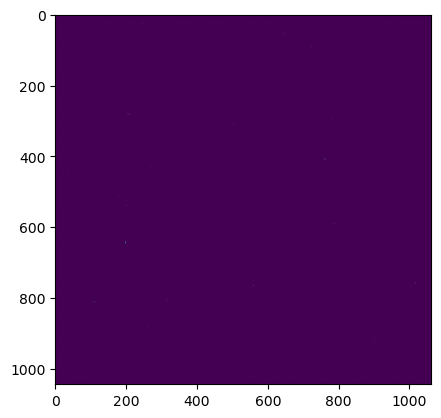

In [76]:
plt.imshow(img)

In [77]:
hdu = fits.open(file)
hdr = hdu[0].header
hdr['BIASCORR']
hdr['CRSPLIT']
#hdr['REPEATOBS']
img = hdu[1].data
from astropy.table import Table
 
data_table = Table.read('/Users/runnojc1/Research/work/psu/ilarion1/runnoejc/Research/projects/smbbh/BBH/uvspec/stis_reduce/data/raw/obji14010_asn.fits', hdu='asn')
data_table

img





FileNotFoundError: [Errno 2] No such file or directory: '/Users/runnojc1/Research/work/psu/ilarion1/runnoejc/Research/projects/smbbh/BBH/uvspec/stis_reduce/data/raw/obji14010_asn.fits'

In [78]:
stistools.basic2d.basic2d("o66p01020_raw.fits", verbose=True,trailer="o66p01020.trl")

No file name matched the string 'o66p01020_raw.fits'


2

In [79]:
    #fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(20, 10))


In [ ]:
stistools.ocrreject.ocrreject("o3tt02020_flt.fits","o3tt02020_crj.fits", verbose=True, trailer="o3tt02020.trl")

In [ ]:
hdu = fits.open('<name_raw.fits>', mode='update')
header = hdu[0].header
header['BIASCORR'] = "PERFORM"
header['BIASFILE'] = "oref$new_bias.fits"
hdu.close()

In [45]:
stistools.basic2d.basic2d("of0a02010_raw.fits", verbose=True,trailer="of0a02010_trl.fits")

Appending to trailer file of0a02010_trl.fits
Running basic2d on of0a02010_raw.fits
  ['cs1.e', '-v', 'of0a02010_raw.fits', '', '-dqi', '-blev', '-dopp', '-lors', '-glin', '-lflg', '-bias', '-dark', '-flat', '-phot', '-stat']


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [33]:
import os

# List all files and directories in the current directory
files_and_directories = os.listdir()

print("Files and directories in current directory:")
for item in files_and_directories:
    print(item)


Files and directories in current directory:
of0a02010.trl
of0a02010_raw.fits
of0a02010_trl.log
of0a02010_trl.txt
of0a02010_wav.fits
of0a02020_raw.fits
of0a02020_wav.fits
of0a02030_raw.fits
of0a02030_wav.fits
of0a02040_raw.fits
of0a02040_wav.fits
of0a02050_raw.fits
of0a02050_wav.fits
of0a02060_raw.fits
of0a02060_wav.fits
of0a02070_raw.fits
of0a02070_wav.fits
of0a02080_raw.fits
of0a02080_wav.fits
of0a02090_raw.fits
of0a02090_wav.fits
of0a020a0_raw.fits
of0a02acj_epc.fits
of0a02acq_raw.fits
of0a02adj_epc.fits
of0a02aej_epc.fits
of0a02afj_epc.fits
of0a02agj_epc.fits
of0a02ahj_epc.fits
of0a02aij_epc.fits
of0a02ajj_epc.fits
of0a02alj_epc.fits
of0a02amj_epc.fits
of0a02anj_epc.fits
of0a02aoj_epc.fits
of0a02aqj_epc.fits
of0a02arj_epc.fits
of0a02asj_epc.fits
